In [0]:
%pip install torch

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import evaluate

In [0]:
print(f"GPU: {torch.cuda.is_available()}")

GPU: True


### prepare data for finetuning

In [0]:
df = pd.read_csv("/Volumes/daz_aitraining_cat/aitraining/aitraining_volume/fed_sentiment_training.csv", sep='\t')

df.head()

,ID,text,sentiment
0,157_1,The action was taken to cushion the effects on...,dovish
1,161_2,Such trends could foster inflationary imbalanc...,hawkish
2,52_0,The Federal Open Market Committee at its meeti...,neutral
3,21_5,Although continuing favorable trends bolster l...,dovish
4,78_7,The Committee perceives that the upside and do...,neutral


In [0]:
# perform train-test split

n = len(df)
test_size = int(0.1 * n)
indices = np.random.RandomState(95).permutation(n)
train_idxs, test_idxs = indices[test_size:], indices[:test_size]

In [0]:
unique_labels = sorted(df['sentiment'].unique())
label2id = {label: idx for idx, label in enumerate(unique_labels)}
print(label2id)
   
df_finetune = df.iloc[train_idxs][["text", "sentiment"]].copy()
df_finetune['labels'] = df_finetune['sentiment'].map(label2id)
print(df_finetune.shape)

df_test = df.iloc[test_idxs][["text", "sentiment"]].copy()
df_test['labels'] = df_test['sentiment'].map(label2id)
print(df_test.shape)

{'dovish': 0, 'hawkish': 1, 'neutral': 2}
(1119, 3)
(124, 3)


In [0]:
df_finetune.head()

,text,sentiment,labels
759,"Consequently, the Committee believes that, for...",dovish,0
439,"In these circumstances, when the economic situ...",neutral,2
548,The Federal Reserve will employ all available ...,dovish,0
657,"Moreover, strains in financial markets have in...",dovish,0
986,"Tight credit conditions, the ongoing housing c...",dovish,0


### use hugging face for finetuning

In [0]:
finetune_dataset = Dataset.from_pandas(df_finetune)
test_dataset = Dataset.from_pandas(df_test)

In [0]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [0]:
# tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], max_length=512, padding="max_length", truncation=True)


# batched=True is key for training
tokenized_ft = finetune_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1119 [00:00<?, ? examples/s]

Map:   0%|          | 0/124 [00:00<?, ? examples/s]

In [0]:
model_ft = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label2id),
    label2id=label2id,
    id2label={idx: label for label, idx in label2id.items()}
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [0]:
training_args = TrainingArguments(
    output_dir="./output",          # path to save model
    learning_rate=5e-5,             # small learning rates
    num_train_epochs=2,             # number of finetuning passes
    per_device_train_batch_size=8,  # batch size per GPU
    per_device_eval_batch_size=8,   # batch size per GPU
    eval_strategy="epoch",          # See metrics during training
    save_strategy="no"              # Don't save checkpoints
)

In [0]:
# model performance metrics

metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")
metric_f1 = evaluate.load("f1")
metric_accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision = metric_precision.compute(predictions=predictions, references=labels, average="micro")["precision"]
    recall = metric_recall.compute(predictions=predictions, references=labels, average="micro")["recall"]
    f1 = metric_f1.compute(predictions=predictions, references=labels, average="micro")["f1"]
    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [0]:
print(f"Training samples: {len(tokenized_ft)}")
print(f"Batches per epoch: {len(tokenized_ft) / 8}")

Training samples: 1119
Batches per epoch: 139.875


In [0]:
trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=tokenized_ft,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.665873,0.790323,0.790323,0.790323,0.790323
2,No log,0.647173,0.854839,0.854839,0.854839,0.854839


TrainOutput(global_step=280, training_loss=0.4196804046630859, metrics={'train_runtime': 99.838, 'train_samples_per_second': 22.416, 'train_steps_per_second': 2.805, 'total_flos': 588847800909824.0, 'train_loss': 0.4196804046630859, 'epoch': 2.0})

### evaluate model on test data

In [0]:
# Get predictions
results = trainer.predict(tokenized_test)
predictions = np.argmax(results.predictions, axis=-1)

# Add to dataframe
df_test['prediction'] = predictions

# Map back to text labels for interpretability
id2label = {idx: label for label, idx in label2id.items()}
df_test['predicted_sentiment'] = df_test['prediction'].map(id2label)
df_test['true_sentiment'] = df_test['labels'].map(id2label)

df_test.head()

,text,sentiment,labels,prediction,predicted_sentiment,true_sentiment
1089,Higher energy and other costs have the potenti...,hawkish,1,1,hawkish,hawkish
557,The Committee will continue to monitor the eco...,neutral,2,0,dovish,neutral
552,The Committee perceives the upside and downsid...,neutral,2,2,neutral,neutral
630,The Committee expects inflation to moderate la...,hawkish,1,1,hawkish,hawkish
464,Information received since the Federal Open Ma...,dovish,0,0,dovish,dovish


In [0]:
# Show mistakes
print("\nMisclassified examples:")
mistakes = df_test[df_test['labels'] != df_test['prediction']]

first_mistake = mistakes.iloc[0]
print(f"Text: {first_mistake['text']}")
print(f"True: {first_mistake['true_sentiment']}")
print(f"Predicted: {first_mistake['predicted_sentiment']}")



Misclassified examples:
Text: The Committee will continue to monitor the economic outlook and financial developments and will employ its policy tools as necessary to promote economic recovery and price stability
True: neutral
Predicted: dovish


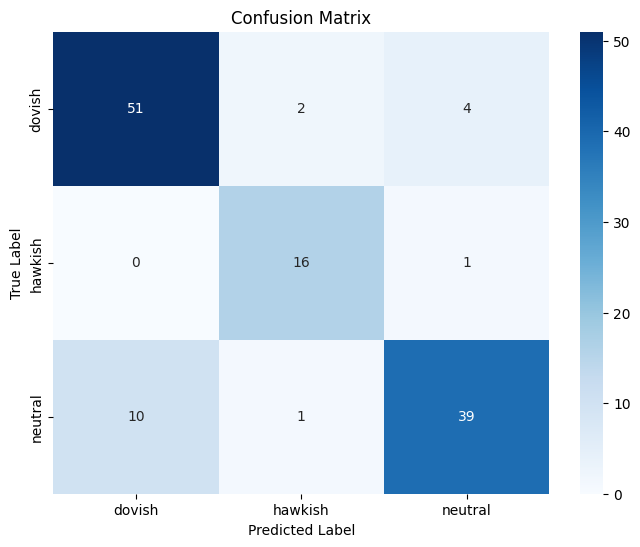

In [0]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_test['labels'], df_test['prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(label2id.keys()),
            yticklabels=sorted(label2id.keys()))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()